In [1]:
from __future__ import unicode_literals, print_function, division

from io import open
import unicodedata
import string
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 将法语翻译成英语

In [2]:
SOS_token = 0  # 开始的标注
EOS_token = 1  # 结束的标注

# 辅助类


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}   # word---->index
        self.index2word = {0: "SOS", 1: "EOS"}  # index---->word
        self.word2count = {}   # 稍后用来替换稀有单词，统计每个单词出现的次数
        self.n_words = 2  # 统计单词总数
    
    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)
    
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
        
        
    

In [3]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 小写，修剪和删除非字母字符
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


In [4]:
# 加载文件
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines.......")
    # 读取文件并进行划分成行
    lines = open(r"E://DeepLearning//jupyter_code//dataset//corpus//translation_data//%s-%s.txt" % (lang1, lang2), encoding='utf-8').\
                read().strip().split("\n")
    
    # 将每行切成一组pairs
    pairs = [[normalizeString(s) for s in l.split("\t")] for l in lines]
    # 将其他语言翻译成英语
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)  
        output_lang = Lang(lang2)   
        
    return input_lang, output_lang, pairs

In [5]:
# 由于有很多例句，为了能快速训练，我们会将数据集修剪成相对简短的句子。这里最大长度是10个单词（包括结束标点符号）

MAX_LENGTH = 10

# 英语前缀
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)    
# print("pairs:\n", pairs)  pairs = [法语,英语]
print(random.choice(pairs))


Reading lines.......
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['elles ont toutes disparu .', 'they re all gone .']


In [7]:
# Encoder 部分


class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size   # 隐藏状态a的大小
        
        self.embedding = nn.Embedding(input_size, hidden_size)  # 词嵌入层
        self.gru = nn.GRU(hidden_size, hidden_size)   # 多层的GRU
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1,1, self.hidden_size, device=device)

In [8]:
# Decoder部分


class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size, device=device)

In [41]:
# Attention 部分
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)  # 注意力权重
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))  # 两个batch之间的矩阵乘法
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    # 隐状态初始化
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [42]:
# 训练模型

# 准备训练数据

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(" ")]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)   # EOS作为encoder编码器网络的结束标志，  SOS作为Decoder解码器网络的开始标志
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair): 
    input_tensor = tensorFromSentence(input_lang, pair[0])   # pair[0]是法语
    targe_tensor = tensorFromSentence(output_lang, pair[1])  # pair[1]是英语
    return (input_tensor, targe_tensor)

In [43]:
# 开始训练

# “tearcher_forcing_ratio将上一时刻的真实目标输出当作下一个时刻的Encoder网络的输入，而不是使用Encoder网络的上一时刻的预测输出作为下一时刻的输入。
tearcher_forcing_ratio = 0.5  

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0
    
    # encoder部分
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    # decoder部分
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    decoder_hidden = encoder_hidden
    
    use_teacher_foring = True if random.random() < tearcher_forcing_ratio else False
    
    # using teacher forcing
    if use_teacher_foring:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  
            
    # 不使用teacher forcing,使用上一时刻的输出作为下一时刻的输入        
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  
            
            loss += criterion(decoder_output, target_tensor[di])
            
            if decoder_input.item() == EOS_token:
                break
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

In [44]:
# 辅助函数------记录时间

import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (- %s)" % (asMinutes(s), asMinutes(rs))

In [45]:
# 整个训练过程如下：
 # 开启定时器
 # 初始化优化器和loss函数
 # 创建training pairs
 # 开始训练并绘图

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()  # 开启定时器
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)  # 定义优化算法
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))  # 创建training pairs
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()  # 定义损失函数

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [53]:
# 绘制loss曲线

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [47]:
# 测试阶段--------测试阶段整体与训练阶段类似，但是测试阶段，不用给出target_tensor,只是将decoder网络上一时刻的预测值作为下一时刻的输入值
# 当预测值是EOS时，则停止预测

def evaluate(encoder, decoder, sentence, max_length = MAX_LENGTH):
     with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # encoder部分
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        # decoder部分
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:  # 结束时的条件
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [48]:
# 随机地从训练集中选择pairs,然后在测试集上进行评估

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('输入:>', pair[0])
        print('目标:=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('预测:<', output_sentence)
        print('')

In [49]:
# 正式训练

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

12m 38s (- 176m 53s) (5000 6%) 2.8686
26m 5s (- 169m 36s) (10000 13%) 2.2863
38m 36s (- 154m 24s) (15000 20%) 1.9313
52m 13s (- 143m 36s) (20000 26%) 1.6717
72m 57s (- 145m 54s) (25000 33%) 1.4735
83m 59s (- 125m 59s) (30000 40%) 1.3135
94m 45s (- 108m 17s) (35000 46%) 1.1881
602m 35s (- 527m 15s) (40000 53%) 1.0446
619m 45s (- 413m 10s) (45000 60%) 0.9321
633m 31s (- 316m 45s) (50000 66%) 0.8471
646m 33s (- 235m 6s) (55000 73%) 0.7750
659m 22s (- 164m 50s) (60000 80%) 0.6759
670m 55s (- 103m 13s) (65000 86%) 0.6046
684m 17s (- 48m 52s) (70000 93%) 0.5711
697m 19s (- 0m 0s) (75000 100%) 0.5304


In [54]:
evaluateRandomly(encoder1, attn_decoder1)

输入:> c est un tres chouette garcon .
目标:= he s a very nice boy .
预测:< he s a very nice boy . <EOS>

输入:> elle souffre d une maladie grave .
目标:= she s suffering from a serious disease .
预测:< she s suffering from a serious . <EOS>

输入:> vous etes fort elegante .
目标:= you re very sophisticated .
预测:< you re very sophisticated . <EOS>

输入:> nous sommes a la moitie du chemin .
目标:= we re halfway there .
预测:< we re halfway there . <EOS>

输入:> il risque d etre expulse .
目标:= he s in danger of being evicted .
预测:< he is in of being being . <EOS>

输入:> je suis content que tu sois toujours la .
目标:= i m glad you re still here .
预测:< i m glad you re still here . <EOS>

输入:> c est toi la chef .
目标:= you re the leader .
预测:< you re the leader . <EOS>

输入:> nous sommes en train de le changer .
目标:= we re changing it .
预测:< we re changing . <EOS>

输入:> on ne rajeunit pas .
目标:= we re not getting any younger .
预测:< we re not getting . <EOS>

输入:> nous sommes a l interieur .
目标:= we re inside .
预测:< w

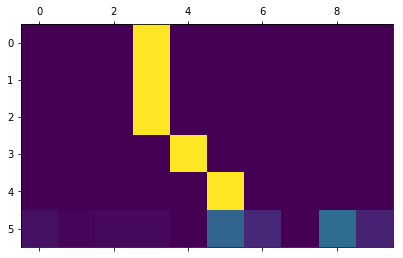

In [56]:
# 注意力可视化

output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy());

input = elle a cinq ans de moins que moi .
output = she s three years younger than me . <EOS>


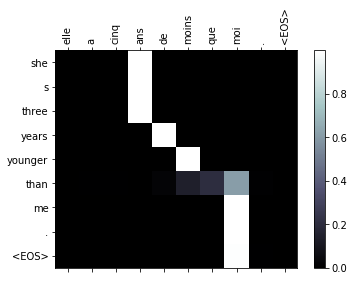

input = elle est trop petit .
output = she s too old . <EOS>


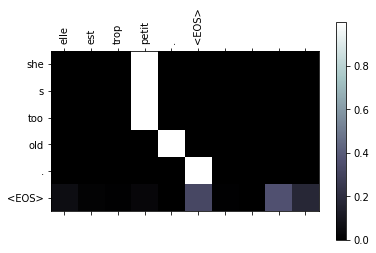

input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>


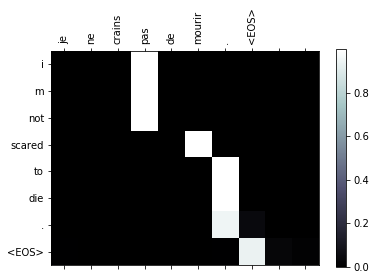

input = c est un jeune directeur plein de talent .
output = he s a talented and . <EOS>


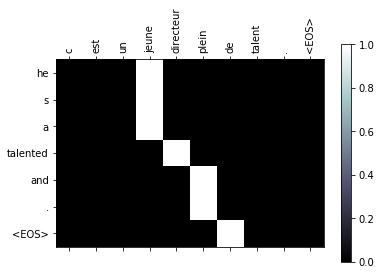

In [57]:
# 增加坐标轴，更加清楚的可视化

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")